# Test the Pressure atmospheric differential transparency Emulator differentiation

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : 2023/10/31
- last update : 2023/10/31


- This emulator is based from datagrid of atmospheric transparencies extracted from libradtran

- It is implemented in jax for auto differentiation

- access to data see https://setuptools.pypa.io/en/latest/userguide/datafiles.html

In [1]:
import numpy as np
import jax.numpy as jnp
from jax import grad, jit,vmap
import pandas as pd
import os
import seaborn as sns

In [2]:
from diffatmpressemulator.diffatmpressemulator  import DiffAtmPressEmulator
from diffatmpressemulator.diffatmpressemulator import Dict_Of_sitesAltitudes,Dict_Of_sitesPressures,final_path_data

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (16, 8),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)
from mpl_toolkits.axes_grid1 import make_axes_locatable
cmap_chosen = "jet"


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# vectorisation 1D and 2D of any jax function

def onemap_2args_1(f):
    return jit(vmap(f, in_axes=(0, None)))

def onemap_2args_2(f):
    return jit(vmap(f, in_axes=(None,0)))

def onemap_3args_1(f):
    return jit(vmap(f, in_axes=(0, None,None)))

def onemap_3args_2(f):
    return jit(vmap(f, in_axes=(None,0,None)))

def onemap_3args_3(f):
    return jit(vmap(f, in_axes=(None,None,0)))


def twomap_2args_12(f):
      return jit(vmap(vmap(f, in_axes=(0, None)), in_axes=(None, 0))) 

def twomap_3args_12(f):
      return jit(vmap(vmap(f, in_axes=(0, None,None)), in_axes=(None, 0,None))) 
def twomap_3args_13(f):
      return jit(vmap(vmap(f, in_axes=(0, None,None)), in_axes=(None, None,0))) 
def twomap_3args_23(f):
      return jit(vmap(vmap(f, in_axes=(None, 0 ,None)), in_axes=(None, None,0))) 

# Check emulator

In [6]:
site = 'LSST'
pressure = 743.0
emul  = DiffAtmPressEmulator(obs_str=site,pressure = pressure)
path = final_path_data

Observatory LSST found in preselected observation sites


In [7]:
WL = emul.GetWL()

In [8]:
airmasses = emul.AIRMASS
NAM = len(airmasses)

In [9]:
hls_colors = sns.color_palette("hls", NAM)
#sns.palplot(hls_colors)

In [10]:
pwvs = emul.PWV
ozs = emul.OZ

# Rayleigh scattering first order derivatives

In [11]:
diff_transm = jit(twomap_2args_12(emul.grad_Rayleightransparency))(WL,airmasses)

Text(0.5, 0.98, 'DiffAtmPressEmulator : 1st order derivative Rayleigh scattering transmission ')

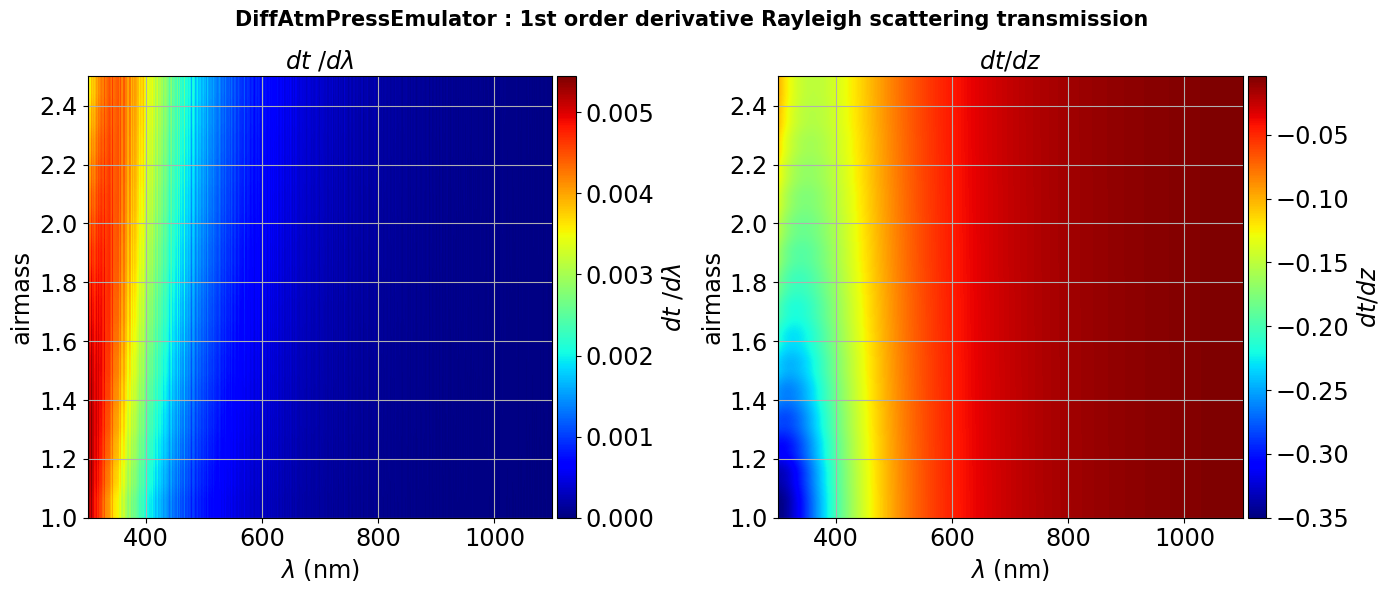

In [12]:
fig, axs = plt.subplots(1,2,figsize=(14,6),tight_layout=True)

subplot_titles = [ "$dt\ / d\\lambda$", "$dt / dz$"]
global_title = f"DiffAtmPressEmulator : 1st order derivative Rayleigh scattering transmission "

for idx,ax in enumerate(axs):
    
    im = ax.imshow(diff_transm[idx],origin="lower",aspect="auto",extent=(WL.min(),WL.max(),airmasses.min(),airmasses.max()),cmap=cmap_chosen)
    ax.set_title(subplot_titles[idx])
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("airmass")
    ax.grid()

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad=0.05)
    cb = fig.colorbar(im, cax=cax, orientation='vertical')
    cb.set_label(subplot_titles[idx])

plt.suptitle(global_title,fontweight="bold",fontsize=15)

# O2  absorption first order derivatives

In [13]:
diff_transm = jit(twomap_2args_12(emul.grad_O2abstransparency))(WL,airmasses)

Text(0.5, 0.98, 'DiffAtmPressEmulator  : 1st order derivative O2 absorption transmission ')

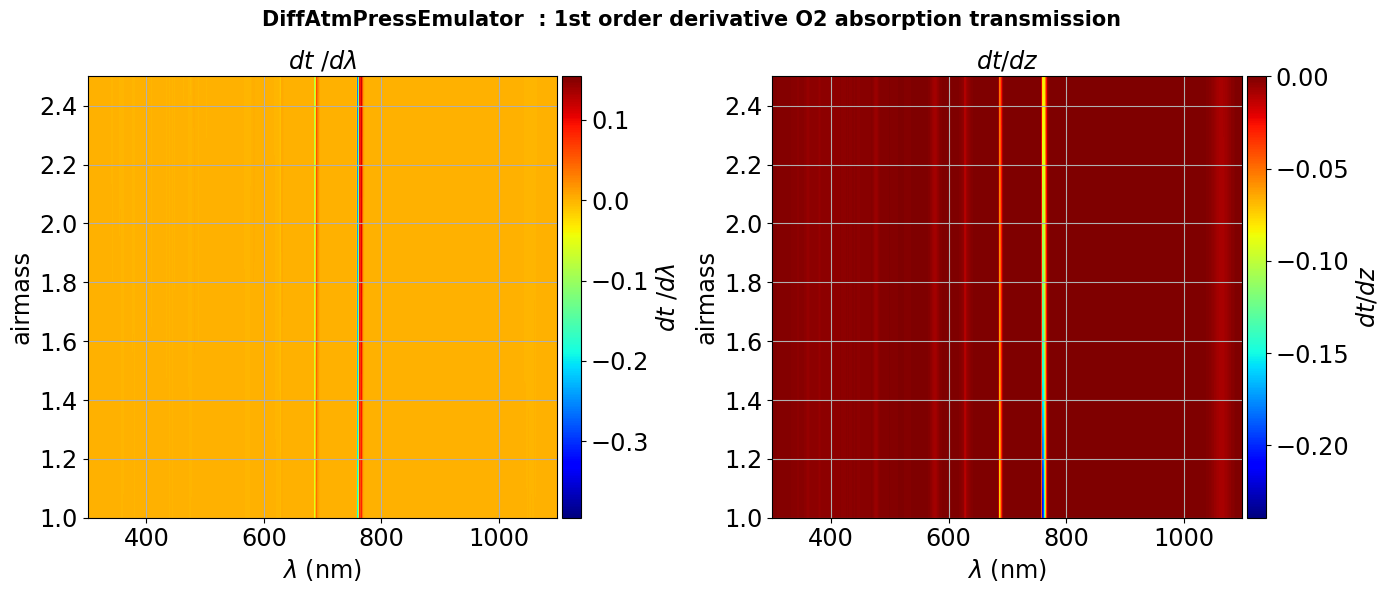

In [14]:
fig, axs = plt.subplots(1,2,figsize=(14,6),tight_layout=True)

subplot_titles = [ "$dt\ / d\\lambda$", "$dt / dz$"]
global_title = f"DiffAtmPressEmulator  : 1st order derivative O2 absorption transmission "

for idx,ax in enumerate(axs):
    
    im = ax.imshow(diff_transm[idx],origin="lower",aspect="auto",extent=(WL.min(),WL.max(),airmasses.min(),airmasses.max()),cmap=cmap_chosen)
    ax.set_title(subplot_titles[idx])
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("airmass")
    ax.grid()

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad=0.05)
    cb = fig.colorbar(im, cax=cax, orientation='vertical')
    cb.set_label(subplot_titles[idx])

plt.suptitle(global_title,fontweight="bold",fontsize=15)

# PWV absorption first order derivatives

In [15]:
pwv = 5.0
diff_transma = jit(twomap_3args_12(emul.grad_PWVabstransparency))(WL,airmasses,pwv)

am=1.0
diff_transmb = jit(twomap_3args_13(emul.grad_PWVabstransparency))(WL,am,pwvs)

In [16]:
# put in a tuple
diff_transm = (diff_transma[0] , diff_transma[1], diff_transmb[0] , diff_transmb[1]) 

Text(0.5, 0.98, 'DiffAtmPressEmulator  : 1st order derivative PWV absorption transmission ')

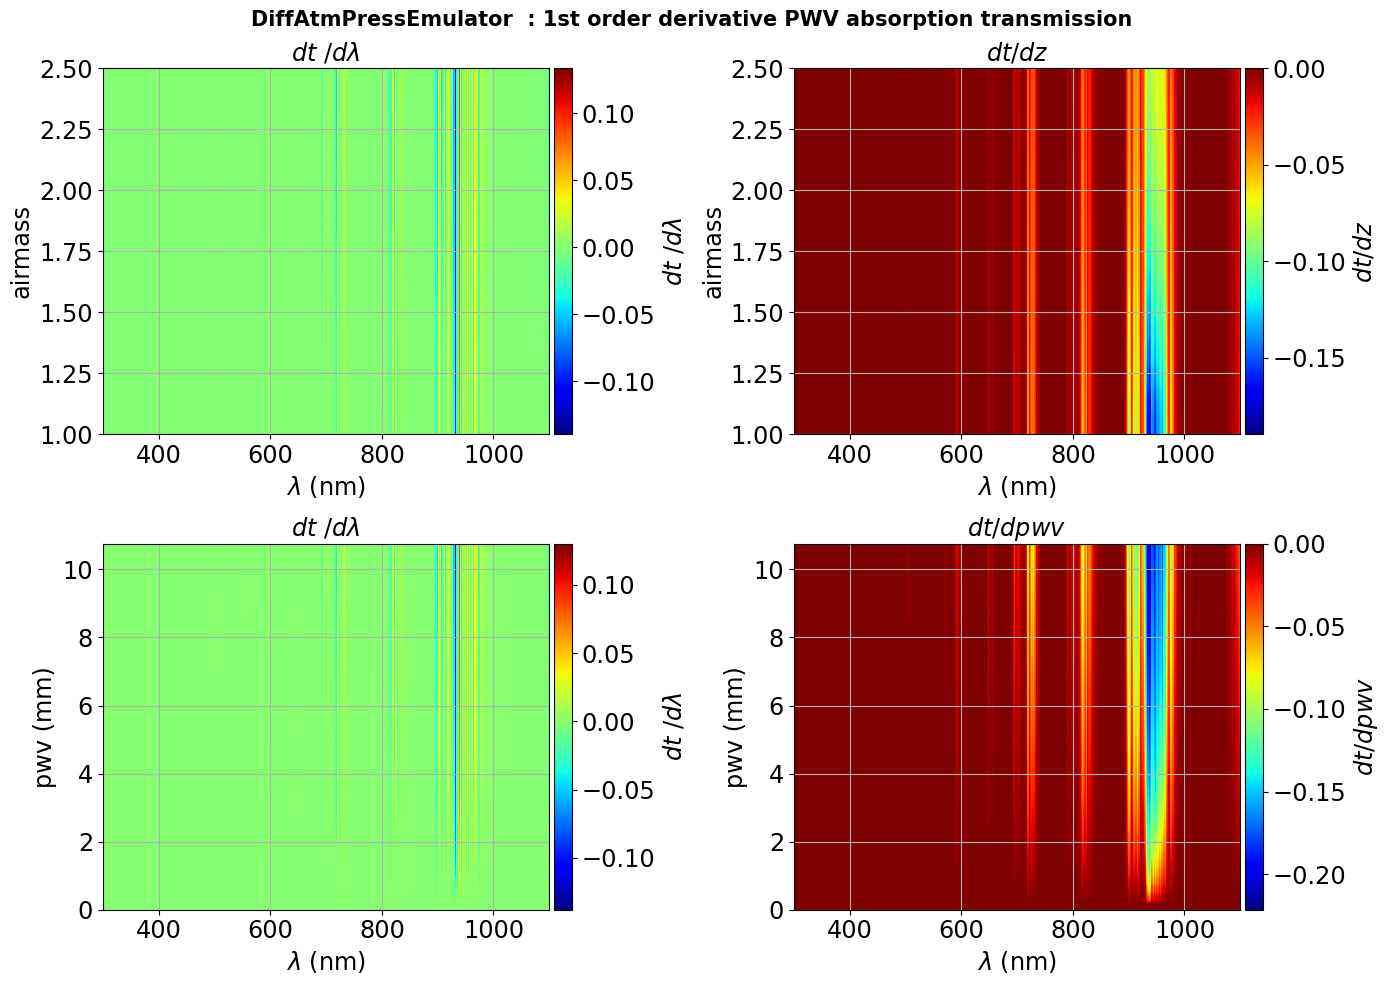

In [17]:
fig, axs = plt.subplots(2,2,figsize=(14,10),tight_layout=True)

axs =axs.flatten()

subplot_titles = [ "$dt\ / d\\lambda$", "$dt / dz$", "$dt\ / d\\lambda$", "$dt / dpwv$"]
global_title = f"DiffAtmPressEmulator  : 1st order derivative PWV absorption transmission "

for idx,ax in enumerate(axs):

    if idx == 0 or idx == 1:
        im = ax.imshow(diff_transm[idx],origin="lower",aspect="auto",extent=(WL.min(),WL.max(),airmasses.min(),airmasses.max()),cmap=cmap_chosen)
        ax.set_xlabel("$\lambda$ (nm)")
        ax.set_ylabel("airmass")

    else:
        im = ax.imshow(diff_transm[idx],origin="lower",aspect="auto",extent=(WL.min(),WL.max(),pwvs.min(),pwvs.max()),cmap=cmap_chosen)
        ax.set_xlabel("$\lambda$ (nm)")
        ax.set_ylabel("pwv (mm)")
    
    ax.set_title(subplot_titles[idx])
    ax.grid()

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad=0.05)
    cb = fig.colorbar(im, cax=cax, orientation='vertical')
    cb.set_label(subplot_titles[idx])

plt.suptitle(global_title,fontweight="bold",fontsize=15)

## OZone absorption first derivative

In [18]:
oz = 500.
diff_transma = jit(twomap_3args_12(emul.grad_OZabstransparency))(WL,airmasses,oz)

am=1.0
diff_transmb = jit(twomap_3args_13(emul.grad_OZabstransparency))(WL,am,ozs)

In [19]:
# put in a tuple
diff_transm = (diff_transma[0] , diff_transma[1], diff_transmb[0] , diff_transmb[1]) 

Text(0.5, 0.98, 'DiffAtmPressEmulator  : 1st order derivative Ozone absorption transmission ')

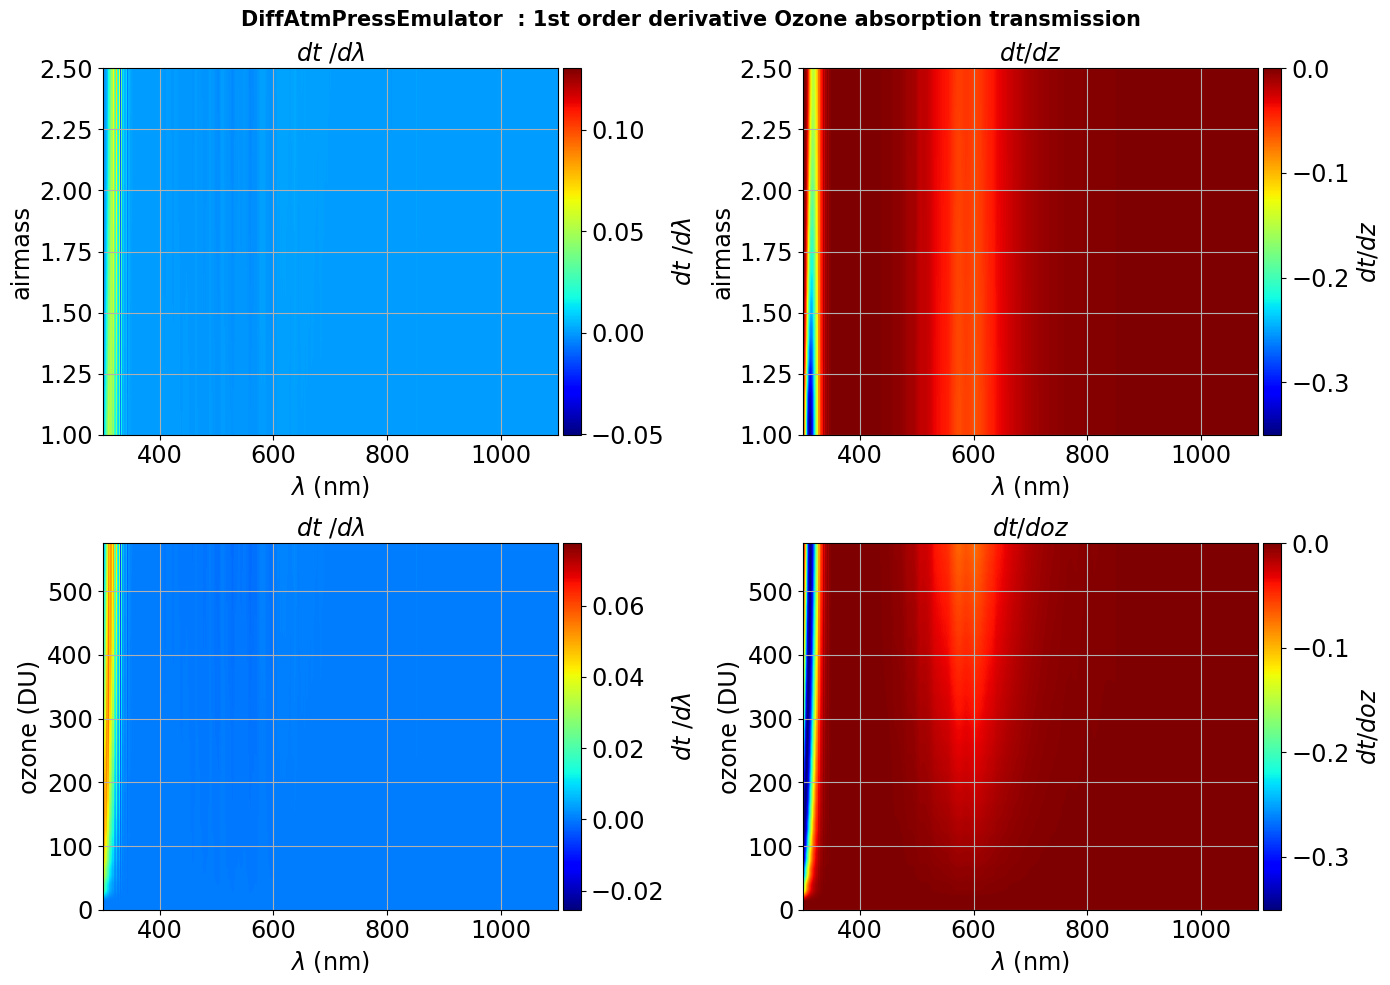

In [20]:
fig, axs = plt.subplots(2,2,figsize=(14,10),tight_layout=True)

axs =axs.flatten()

subplot_titles = [ "$dt\ / d\\lambda$", "$dt / dz$", "$dt\ / d\\lambda$", "$dt / doz$"]
global_title = f"DiffAtmPressEmulator  : 1st order derivative Ozone absorption transmission "

for idx,ax in enumerate(axs):

    if idx == 0 or idx == 1:
        im = ax.imshow(diff_transm[idx],origin="lower",aspect="auto",extent=(WL.min(),WL.max(),airmasses.min(),airmasses.max()),cmap=cmap_chosen)
        ax.set_xlabel("$\lambda$ (nm)")
        ax.set_ylabel("airmass")

    else:
        im = ax.imshow(diff_transm[idx],origin="lower",aspect="auto",extent=(WL.min(),WL.max(),ozs.min(),ozs.max()),cmap=cmap_chosen)
        ax.set_xlabel("$\lambda$ (nm)")
        ax.set_ylabel("ozone (DU)")
    
    ax.set_title(subplot_titles[idx])
    ax.grid()

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad=0.05)
    cb = fig.colorbar(im, cax=cax, orientation='vertical')
    cb.set_label(subplot_titles[idx])

plt.suptitle(global_title,fontweight="bold",fontsize=15)

# Rayleigh scattering second order derivatives - hessian

## derivative wrt lambda

In [21]:
diff_transm = jit(onemap_2args_1(emul.grad_Rayleightransparency))(WL,2.0)
diff2_transm = jit(onemap_2args_1(emul.hessian_Rayleightransparency))(WL,2.0)

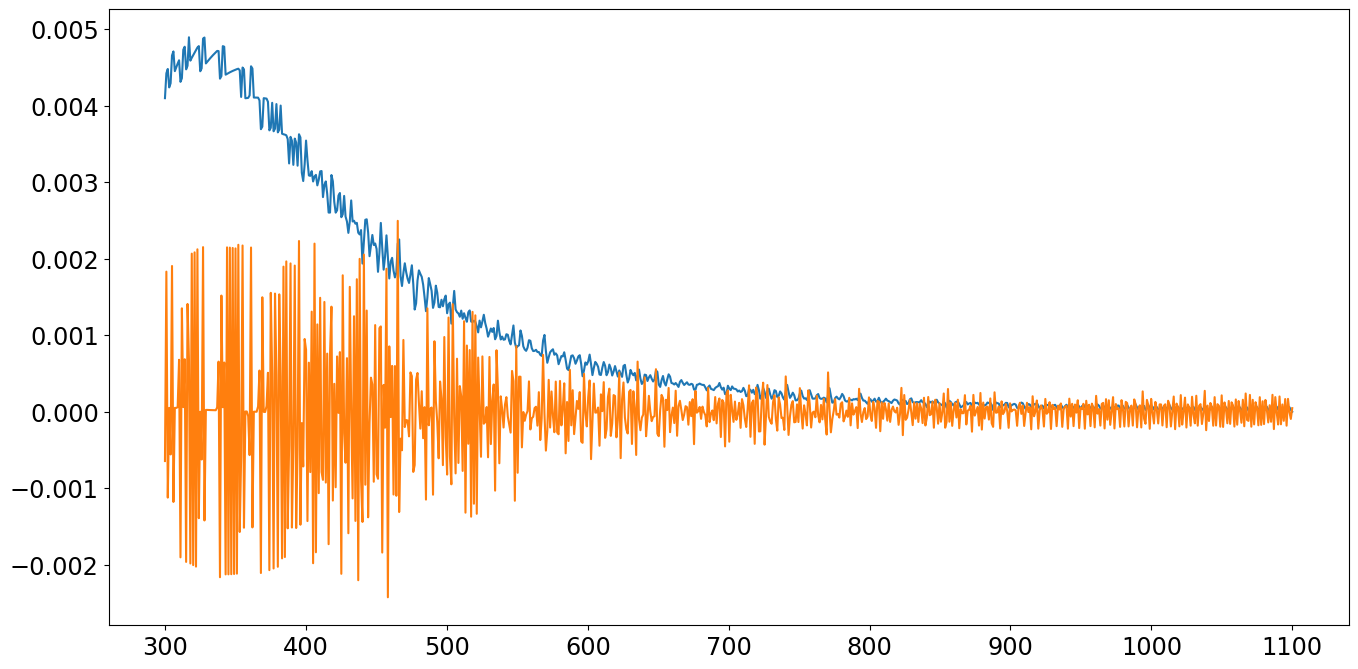

In [22]:
plt.plot(WL,diff_transm[0])
plt.plot(WL,diff2_transm[0][0])

In [23]:
many_airmasses = jnp.linspace(airmasses.min(),airmasses.max(),50)

In [24]:
diff_transm = jit(twomap_2args_12(emul.hessian_Rayleightransparency))(WL,many_airmasses)

In [25]:
diff_transm 

((Array([[-7.10853725e-04,  2.13060249e-03, -1.41263905e-03, ...,
          -1.51815379e-06, -4.67359241e-05,  2.37303084e-05],
         [-7.14653579e-04,  2.13836087e-03, -1.41432020e-03, ...,
          -1.58174885e-06, -4.81175593e-05,  2.46522213e-05],
         [-7.18384166e-04,  2.14627478e-03, -1.41610962e-03, ...,
          -1.93721507e-06, -4.92566178e-05,  2.59566350e-05],
         ...,
         [-5.54031343e-04,  1.53986050e-03, -9.12183546e-04, ...,
          -3.69317263e-06, -1.13854687e-04,  5.69389813e-05],
         [-5.47411735e-04,  1.51929189e-03, -8.97752470e-04, ...,
          -3.11591816e-06, -1.15902614e-04,  5.76430757e-05],
         [-5.40803128e-04,  1.49875390e-03, -8.83313012e-04, ...,
          -2.55713962e-06, -1.18095952e-04,  5.83236542e-05]],      dtype=float32),
  Array([[ 3.33165197e-04,  3.94294795e-04,  4.59205738e-04, ...,
           2.90189946e-05,  1.14858285e-05, -6.04657032e-07],
         [ 3.98832693e-04,  4.64692159e-04,  5.29679295e-04, ...,
  

In [26]:
diff_transm =  (diff_transm[0][0], diff_transm[0][1],diff_transm[1][0], diff_transm[1][1])

Text(0.5, 0.98, 'DiffAtmPressEmulator  : 2nd order derivative of Rayleigh transmission ')

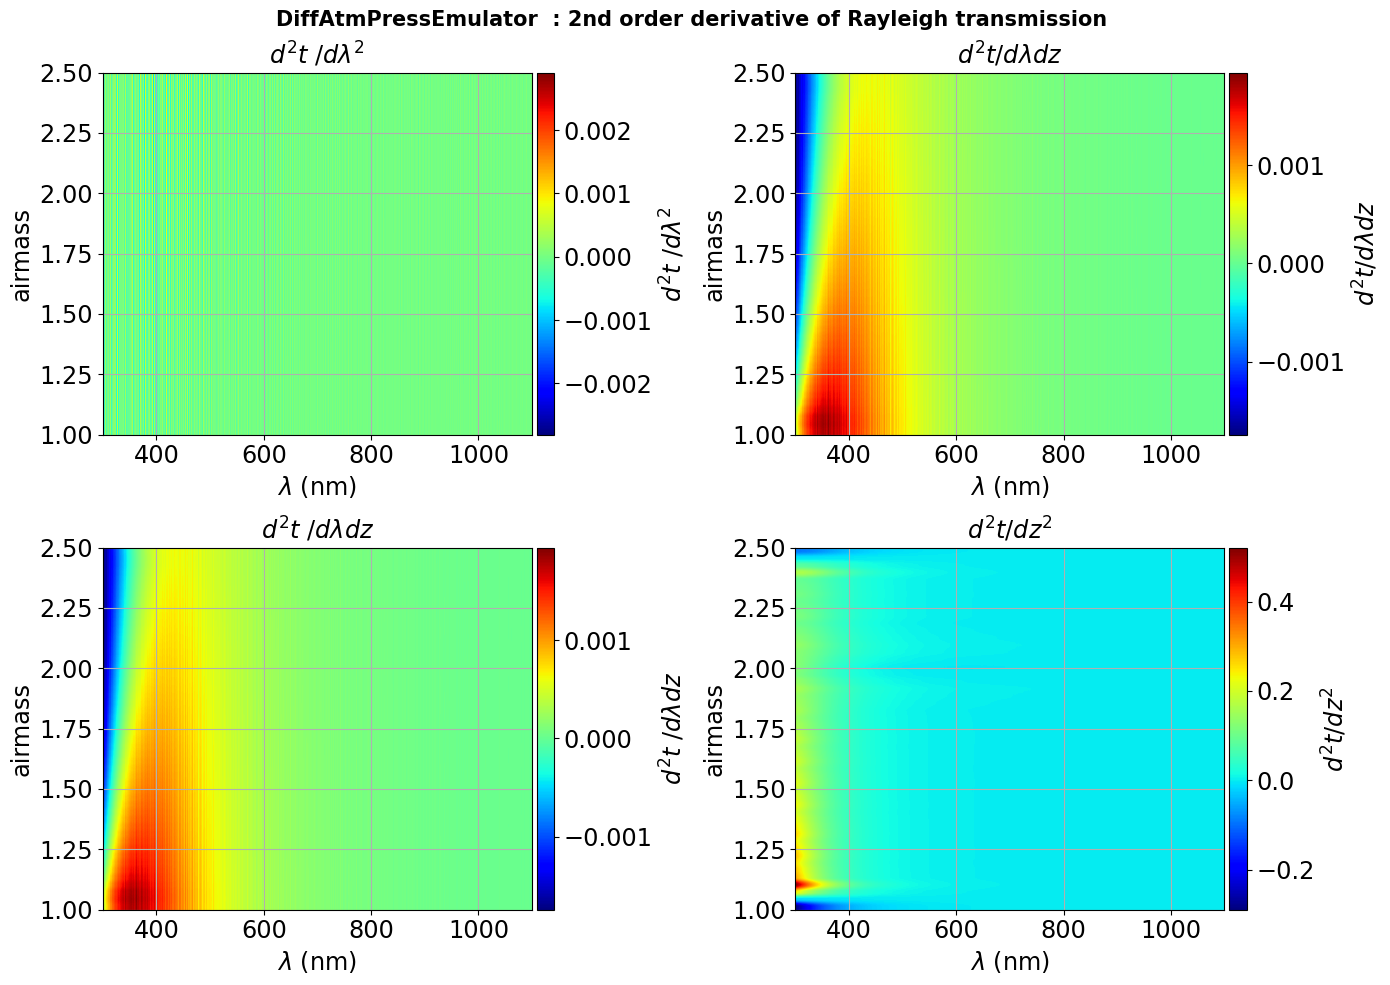

In [27]:
fig, axs = plt.subplots(2,2,figsize=(14,10),tight_layout=True)

axs =axs.flatten()

subplot_titles = [ "$d^2t\ / d\\lambda^2$", "$d^2t / d\\lambda dz$", "$d^2t\ / d\\lambda dz$", "$d^2t / dz^2$"]
global_title = f"DiffAtmPressEmulator  : 2nd order derivative of Rayleigh transmission "

for idx,ax in enumerate(axs):

    
    im = ax.imshow(diff_transm[idx],origin="lower",aspect="auto",extent=(WL.min(),WL.max(),airmasses.min(),airmasses.max()),cmap=cmap_chosen)
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("airmass")

    
    ax.set_title(subplot_titles[idx])
    ax.grid()

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='4%', pad=0.05)
    cb = fig.colorbar(im, cax=cax, orientation='vertical')
    cb.set_label(subplot_titles[idx])

plt.suptitle(global_title,fontweight="bold",fontsize=15)